# Emission Measure Slopes
Compute emission measure slopes from average intensities

In [199]:
import os
import sys
import glob

import numpy as np
from scipy.interpolate import splev
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sunpy.map import Map
import astropy.units as u
from astropy.visualization import ImageNormalize,SqrtStretch,AsinhStretch
from astropy.coordinates import SkyCoord
import distributed
import astropy.time
import sunpy.time
import hissw

import synthesizAR
from synthesizAR.instruments import InstrumentSDOAIA

%matplotlib inline

In [132]:
columnwidth = 2544.81458 #document width of my poster

In [133]:
def get_figsize(wf=0.5, hf=(5.**0.5-1.0)/2.0, ):
    """Parameters:
      - wf [float]:  width fraction in columnwidth units
      - hf [float]:  height fraction in columnwidth units.
                     Set by default to golden ratio.
      - cwidth [float]: width of the column in latex. Get this from LaTeX 
                             using \showthe\columnwidth
    Returns:  [fig_width,fig_height]: that should be given to matplotlib
    """
    fig_width_pt = columnwidth*wf 
    inches_per_pt = 1.0/72.27               # Convert pt to inch
    fig_width = fig_width_pt*inches_per_pt  # width in inches
    fig_height = fig_width*hf      # height in inches
    return (fig_width, fig_height)

## Compute Average Intensities
Need to do this on Nikola because this is where the data lives. We want to compute the average intensities for all channels for all three nanoflare heating functions plus the observations

In [2]:
sys.path.append(os.path.join(os.environ['HOME'], 'projects/synthesized_timelag_maps/scripts/'))
from aiacube import DistributedAIACube,DistributedAIACollection

In [3]:
cluster = distributed.LocalCluster(n_workers=64,threads_per_worker=1)
client = distributed.Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:35802 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 64 Cores: 64 Memory: 270.38 GB


First the models

In [4]:
channels = [94,131,171,193,211,335]
read_template = '/storage-home/w/wtb2/data/timelag_synthesis_v2/{}_frequency/nei/SDO_AIA/{}/map_t{:06d}.fits'
save_template = '/storage-home/w/wtb2/data/shine2018/{}_{}_time_average.fits'

In [9]:
for f in ['high','intermediate','low']:
    for c in channels:
        cube = DistributedAIACube.from_files([read_template.format(f,c,i) for i in range(500,2500)])
        cube.average().save(save_template.format(f,c))

then the data

In [5]:
read_template_data = '/storage-home/w/wtb2/data/timelag_synthesis_v2/observational_data/aia/cutouts/aia_lev1.5_201102*_{}_cutout.fits'

In [6]:
for c in channels:
    cube = DistributedAIACube.from_files(read_template_data.format(c))
    cube.average().save(save_template.format('observed',c))

## Compute Emission Measures
Compute the DEM using the method of Hannah and Kontar (2012) using the average intensities. 

In [2]:
sys.path.append('../scripts')
from dem import HannahKontarModel

First, create the AIA instrument. This will give us the needed response functions.

In [3]:
aia = InstrumentSDOAIA([0,1]*u.s,None)

In [4]:
temperature_bin_edges = 10.**np.arange(5.3,7.3,0.2) * u.K
temperature_bin_centers = (temperature_bin_edges[1:] + temperature_bin_edges[:-1])/2.

In [5]:
responses = [splev(temperature_bin_centers.value, c['temperature_response_spline']) for c in aia.channels]

### High

In [52]:
filenames = sorted(glob.glob('/Users/willbarnes/Downloads/shine2018_temp/high*_time_average.fits'),
                   key=lambda x:int(os.path.basename(x).split('_')[1]))
maps = [sunpy.map.Map(f) for f in filenames]

/Users/willbarnes/anaconda/envs/synthesized-timelags/lib/python3.6/site-packages/sunpy/map/sources/sdo.py:48: SunpyDeprecationWarning: Use Matplotlib to load the colormaps
  self.plot_settings['cmap'] = cm.get_cmap(self._get_cmap_name())


In [53]:
hk_model = HannahKontarModel(maps, temperature_bin_edges, responses,
                             dem_path='/Users/willbarnes/Documents/work/codes/demreg/idl')

In [54]:
em_high = hk_model.fit()

IDL Version 8.5, Mac OS X (darwin x86_64 m64).
(c) 2015, Exelis Visual Information Solutions, Inc., a subsidiary of Harris Corporation.
Installation number: 401801-1.
Licensed for use by: Rice University

% Compiled module: SSW_PATH.
% Compiled module: SSW_INSTRUMENTS.
% Compiled module: WC_WHERE.
% Compiled module: PATHFIX.
% Compiled module: UNIQO.
% Compiled module: STRJUSTIFY.
% Compiled module: UNIQ.
% Compiled module: DEFAULT.
% Compiled module: PRSTR.
% SSW_PATH: Number of paths changed from 91 to 106
% Compiled module: HISSW_PROCEDURE.
% Compiled module: AIA_BP_READ_ERROR_TABLE.
% Compiled module: RD_TFILE.
% Compiled module: AIA_BP_ESTIMATE_ERROR.
% Compiled module: DN2DEM_POS_NB.
% Compiled module: GET_EDGES.
% Compiled module: EDGE_PRODUCTS.
% Compiled module: INTERPOL.
% Compiled module: DEMMAP_POS.
% Compiled module: DEM_INV_GSVDCSQ.
% Compiled module: DEM_INV_REG_PARAMETER_MAP.

SSW  setup will include: <gen sdo/aia>

Type <sswidl> to start SSW IDL
-----------------------

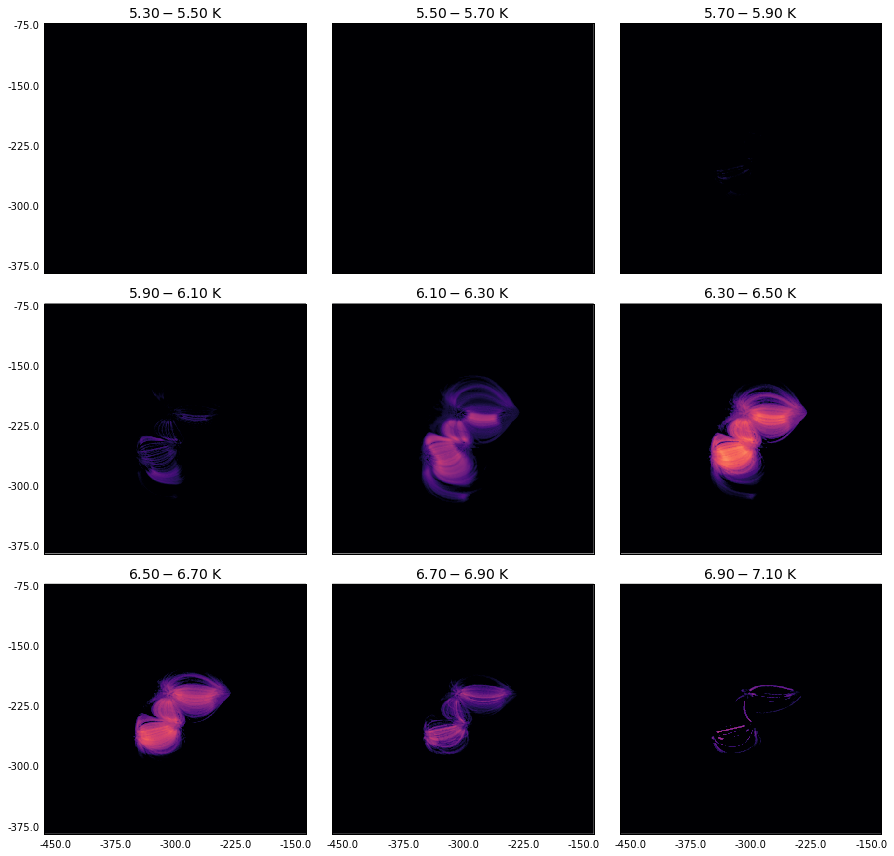

In [77]:
fig = plt.figure(figsize=(15,15))
plt.subplots_adjust(wspace=0.1,hspace=0.1)
for i in range(len(em_high.maps)):
    tmp = em_high[i]
    ax = fig.add_subplot(3,3,i+1,projection=tmp)
    tmp.plot(annotate=False,title=False,axes=ax,norm=matplotlib.colors.SymLogNorm(1,vmin=1e25,vmax=1e29))
    ax.grid(alpha=0)
    lon = ax.coords[0]
    lat = ax.coords[1]
    lon.set_ticks_visible(False)
    lat.set_ticks_visible(False)
    if i%3 != 0:
        lat.set_ticklabel_visible(False)
    if i < 6:
        lon.set_ticklabel_visible(False)
    ax.set_title(f'${np.log10(tmp.meta["temp_a"]):.2f}-{np.log10(tmp.meta["temp_b"]):.2f}$ K')

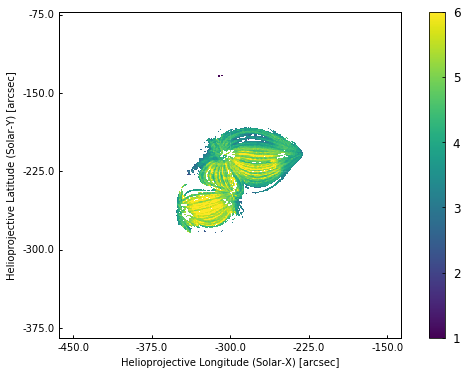

In [81]:
slope_map = em_high.make_slope_map(temperature_bounds=[1,4]*u.MK,em_threshold=1e20*u.cm**-5,rsquared_tolerance=0.9)
slope_map_high = sunpy.map.Map(np.where(slope_map.data == 0, np.nan, slope_map.data),slope_map.meta)
#slope_map = slope_map.submap(SkyCoord(Tx=-400*u.arcsec,Ty=-300*u.arcsec,frame=slope_map.coordinate_frame),
#                             SkyCoord(Tx=-220*u.arcsec,Ty=-175*u.arcsec,frame=slope_map.coordinate_frame))
fig = plt.figure(figsize=(10,6))
ax = fig.gca(projection=slope_map_high)
im = slope_map_high.plot(axes=ax,cmap='viridis',vmin=1,vmax=6,title=False)
fig.colorbar(im,ax=ax)

## Intermediate

In [66]:
filenames = sorted(glob.glob('/Users/willbarnes/Downloads/shine2018_temp/intermediate*_time_average.fits'),
                   key=lambda x:int(os.path.basename(x).split('_')[1]))
maps = [sunpy.map.Map(f) for f in filenames]

/Users/willbarnes/anaconda/envs/synthesized-timelags/lib/python3.6/site-packages/sunpy/map/sources/sdo.py:48: SunpyDeprecationWarning: Use Matplotlib to load the colormaps
  self.plot_settings['cmap'] = cm.get_cmap(self._get_cmap_name())


In [67]:
hk_model = HannahKontarModel(maps, temperature_bin_edges, responses,
                             dem_path='/Users/willbarnes/Documents/work/codes/demreg/idl')

In [68]:
em_intermediate = hk_model.fit()

IDL Version 8.5, Mac OS X (darwin x86_64 m64).
(c) 2015, Exelis Visual Information Solutions, Inc., a subsidiary of Harris Corporation.
Installation number: 401801-1.
Licensed for use by: Rice University

% Compiled module: SSW_PATH.
% Compiled module: SSW_INSTRUMENTS.
% Compiled module: WC_WHERE.
% Compiled module: PATHFIX.
% Compiled module: UNIQO.
% Compiled module: STRJUSTIFY.
% Compiled module: UNIQ.
% Compiled module: DEFAULT.
% Compiled module: PRSTR.
% SSW_PATH: Number of paths changed from 91 to 106
% Compiled module: HISSW_PROCEDURE.
% Compiled module: AIA_BP_READ_ERROR_TABLE.
% Compiled module: RD_TFILE.
% Compiled module: AIA_BP_ESTIMATE_ERROR.
% Compiled module: DN2DEM_POS_NB.
% Compiled module: GET_EDGES.
% Compiled module: EDGE_PRODUCTS.
% Compiled module: INTERPOL.
% Compiled module: DEMMAP_POS.
% Compiled module: DEM_INV_GSVDCSQ.
% Compiled module: DEM_INV_REG_PARAMETER_MAP.

SSW  setup will include: <gen sdo/aia>

Type <sswidl> to start SSW IDL
-----------------------

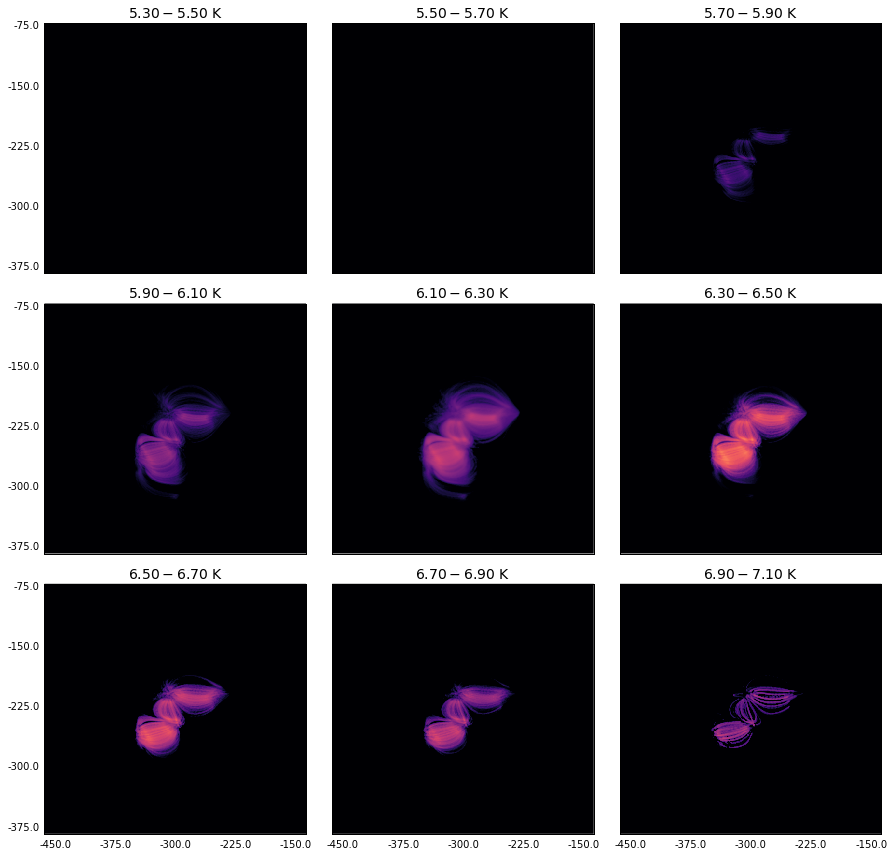

In [69]:
fig = plt.figure(figsize=(15,15))
plt.subplots_adjust(wspace=0.1,hspace=0.1)
for i in range(len(em_intermediate.maps)):
    tmp = em_intermediate[i]
    ax = fig.add_subplot(3,3,i+1,projection=tmp)
    tmp.plot(annotate=False,title=False,axes=ax,norm=matplotlib.colors.SymLogNorm(1,vmin=1e25,vmax=1e29))
    ax.grid(alpha=0)
    lon = ax.coords[0]
    lat = ax.coords[1]
    lon.set_ticks_visible(False)
    lat.set_ticks_visible(False)
    if i%3 != 0:
        lat.set_ticklabel_visible(False)
    if i < 6:
        lon.set_ticklabel_visible(False)
    ax.set_title(f'${np.log10(tmp.meta["temp_a"]):.2f}-{np.log10(tmp.meta["temp_b"]):.2f}$ K')

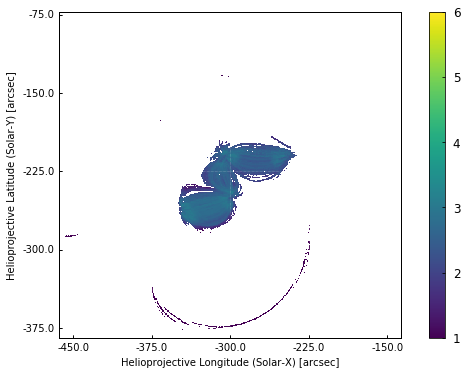

In [82]:
slope_map = em_intermediate.make_slope_map(temperature_bounds=[1,4]*u.MK,em_threshold=1e20*u.cm**-5,rsquared_tolerance=0.9)
slope_map_intermediate = sunpy.map.Map(np.where(slope_map.data == 0, np.nan, slope_map.data),slope_map.meta)
#slope_map = slope_map.submap(SkyCoord(Tx=-400*u.arcsec,Ty=-300*u.arcsec,frame=slope_map.coordinate_frame),
#                             SkyCoord(Tx=-220*u.arcsec,Ty=-175*u.arcsec,frame=slope_map.coordinate_frame))
fig = plt.figure(figsize=(10,6))
ax = fig.gca(projection=slope_map_intermediate)
im = slope_map_intermediate.plot(axes=ax,cmap='viridis',vmin=1,vmax=6,title=False)
fig.colorbar(im,ax=ax)

### Low

In [71]:
filenames = sorted(glob.glob('/Users/willbarnes/Downloads/shine2018_temp/low*_time_average.fits'),
                   key=lambda x:int(os.path.basename(x).split('_')[1]))
maps = [sunpy.map.Map(f) for f in filenames]

/Users/willbarnes/anaconda/envs/synthesized-timelags/lib/python3.6/site-packages/sunpy/map/sources/sdo.py:48: SunpyDeprecationWarning: Use Matplotlib to load the colormaps
  self.plot_settings['cmap'] = cm.get_cmap(self._get_cmap_name())


In [72]:
hk_model = HannahKontarModel(maps, temperature_bin_edges, responses,
                             dem_path='/Users/willbarnes/Documents/work/codes/demreg/idl')

In [73]:
em_low = hk_model.fit()

IDL Version 8.5, Mac OS X (darwin x86_64 m64).
(c) 2015, Exelis Visual Information Solutions, Inc., a subsidiary of Harris Corporation.
Installation number: 401801-1.
Licensed for use by: Rice University

% Compiled module: SSW_PATH.
% Compiled module: SSW_INSTRUMENTS.
% Compiled module: WC_WHERE.
% Compiled module: PATHFIX.
% Compiled module: UNIQO.
% Compiled module: STRJUSTIFY.
% Compiled module: UNIQ.
% Compiled module: DEFAULT.
% Compiled module: PRSTR.
% SSW_PATH: Number of paths changed from 91 to 106
% Compiled module: HISSW_PROCEDURE.
% Compiled module: AIA_BP_READ_ERROR_TABLE.
% Compiled module: RD_TFILE.
% Compiled module: AIA_BP_ESTIMATE_ERROR.
% Compiled module: DN2DEM_POS_NB.
% Compiled module: GET_EDGES.
% Compiled module: EDGE_PRODUCTS.
% Compiled module: INTERPOL.
% Compiled module: DEMMAP_POS.
% Compiled module: DEM_INV_GSVDCSQ.
% Compiled module: DEM_INV_REG_PARAMETER_MAP.

SSW  setup will include: <gen sdo/aia>

Type <sswidl> to start SSW IDL
-----------------------

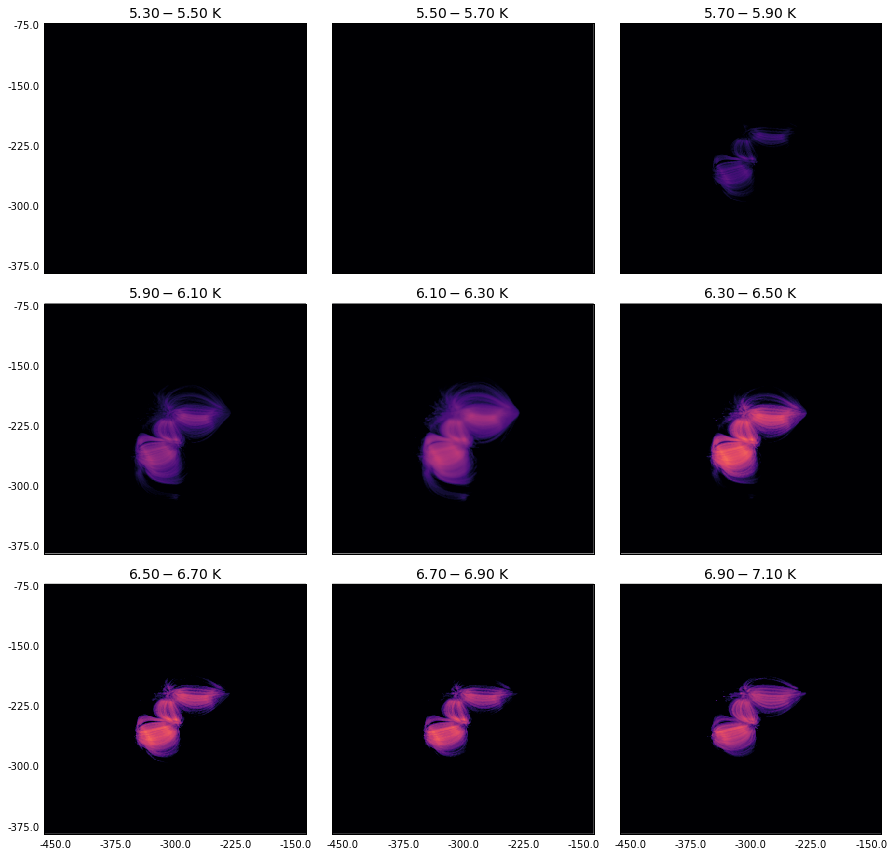

In [74]:
fig = plt.figure(figsize=(15,15))
plt.subplots_adjust(wspace=0.1,hspace=0.1)
for i in range(len(em_low.maps)):
    tmp = em_low[i]
    ax = fig.add_subplot(3,3,i+1,projection=tmp)
    tmp.plot(annotate=False,title=False,axes=ax,norm=matplotlib.colors.SymLogNorm(1,vmin=1e25,vmax=1e29))
    ax.grid(alpha=0)
    lon = ax.coords[0]
    lat = ax.coords[1]
    lon.set_ticks_visible(False)
    lat.set_ticks_visible(False)
    if i%3 != 0:
        lat.set_ticklabel_visible(False)
    if i < 6:
        lon.set_ticklabel_visible(False)
    ax.set_title(f'${np.log10(tmp.meta["temp_a"]):.2f}-{np.log10(tmp.meta["temp_b"]):.2f}$ K')

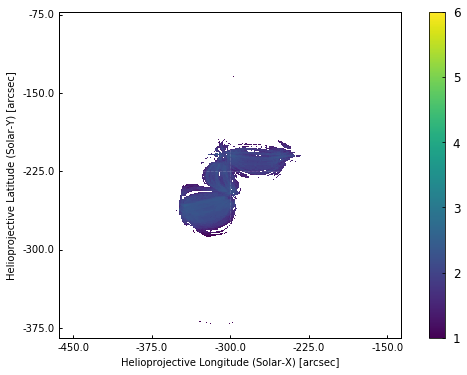

In [83]:
slope_map = em_low.make_slope_map(temperature_bounds=[1,4]*u.MK,em_threshold=1e20*u.cm**-5,rsquared_tolerance=0.9)
slope_map_low = sunpy.map.Map(np.where(slope_map.data == 0, np.nan, slope_map.data),slope_map.meta)
#slope_map = slope_map.submap(SkyCoord(Tx=-400*u.arcsec,Ty=-300*u.arcsec,frame=slope_map.coordinate_frame),
#                             SkyCoord(Tx=-220*u.arcsec,Ty=-175*u.arcsec,frame=slope_map.coordinate_frame))
fig = plt.figure(figsize=(10,6))
ax = fig.gca(projection=slope_map_low)
im = slope_map_low.plot(axes=ax,cmap='viridis',vmin=1,vmax=6,title=False)
fig.colorbar(im,ax=ax)

### Observed

In [61]:
filenames = sorted(glob.glob('/Users/willbarnes/Downloads/shine2018_temp/observed*_time_average.fits'),
                   key=lambda x:int(os.path.basename(x).split('_')[1])
                  )
maps = [sunpy.map.Map(f) for f in filenames]

/Users/willbarnes/anaconda/envs/synthesized-timelags/lib/python3.6/site-packages/sunpy/map/sources/sdo.py:48: SunpyDeprecationWarning: Use Matplotlib to load the colormaps
  self.plot_settings['cmap'] = cm.get_cmap(self._get_cmap_name())


In [62]:
hk_model = HannahKontarModel(maps, temperature_bin_edges, responses,
                             dem_path='/Users/willbarnes/Documents/work/codes/demreg/idl')

In [63]:
em_observed = hk_model.fit()

IDL Version 8.5, Mac OS X (darwin x86_64 m64).
(c) 2015, Exelis Visual Information Solutions, Inc., a subsidiary of Harris Corporation.
Installation number: 401801-1.
Licensed for use by: Rice University

% Compiled module: SSW_PATH.
% Compiled module: SSW_INSTRUMENTS.
% Compiled module: WC_WHERE.
% Compiled module: PATHFIX.
% Compiled module: UNIQO.
% Compiled module: STRJUSTIFY.
% Compiled module: UNIQ.
% Compiled module: DEFAULT.
% Compiled module: PRSTR.
% SSW_PATH: Number of paths changed from 91 to 106
% Compiled module: HISSW_PROCEDURE.
% Compiled module: AIA_BP_READ_ERROR_TABLE.
% Compiled module: RD_TFILE.
% Compiled module: AIA_BP_ESTIMATE_ERROR.
% Compiled module: DN2DEM_POS_NB.
% Compiled module: GET_EDGES.
% Compiled module: EDGE_PRODUCTS.
% Compiled module: INTERPOL.
% Compiled module: DEMMAP_POS.
% Compiled module: DEM_INV_GSVDCSQ.
% Compiled module: DEM_INV_REG_PARAMETER_MAP.

SSW  setup will include: <gen sdo/aia>

Type <sswidl> to start SSW IDL
-----------------------

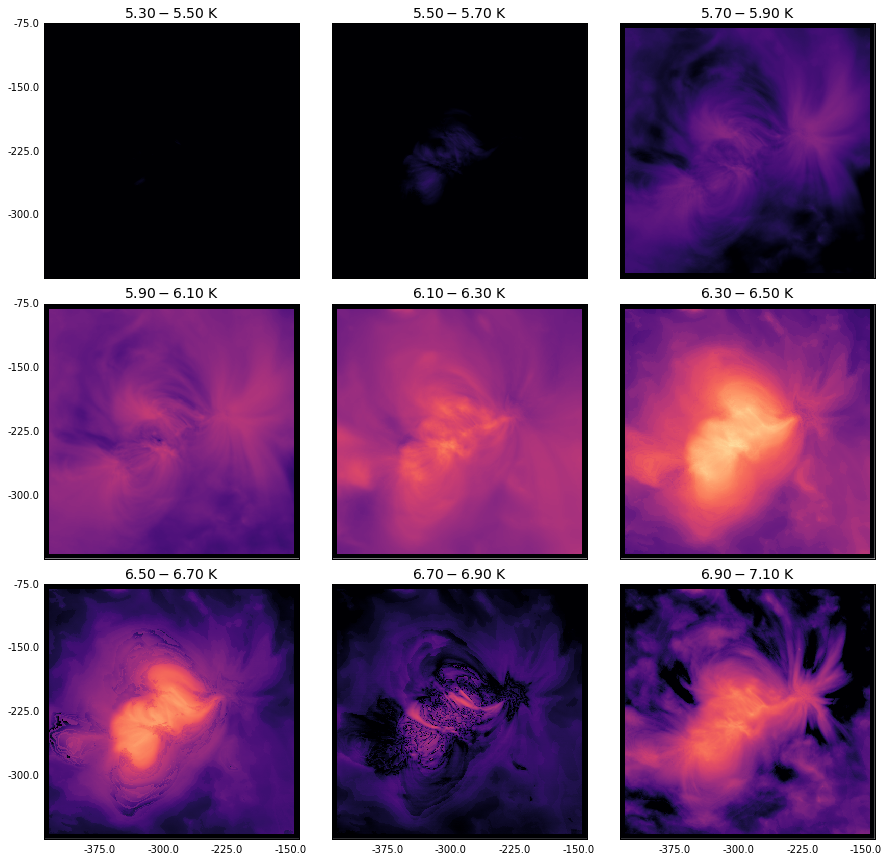

In [64]:
fig = plt.figure(figsize=(15,15))
plt.subplots_adjust(wspace=0.1,hspace=0.1)
for i in range(len(em_observed.maps)):
    tmp = em_observed[i]
    ax = fig.add_subplot(3,3,i+1,projection=tmp)
    tmp.plot(annotate=False,title=False,axes=ax,norm=matplotlib.colors.SymLogNorm(1,vmin=1e25,vmax=1e29))
    ax.grid(alpha=0)
    lon = ax.coords[0]
    lat = ax.coords[1]
    lon.set_ticks_visible(False)
    lat.set_ticks_visible(False)
    if i%3 != 0:
        lat.set_ticklabel_visible(False)
    if i < 6:
        lon.set_ticklabel_visible(False)
    ax.set_title(f'${np.log10(tmp.meta["temp_a"]):.2f}-{np.log10(tmp.meta["temp_b"]):.2f}$ K')

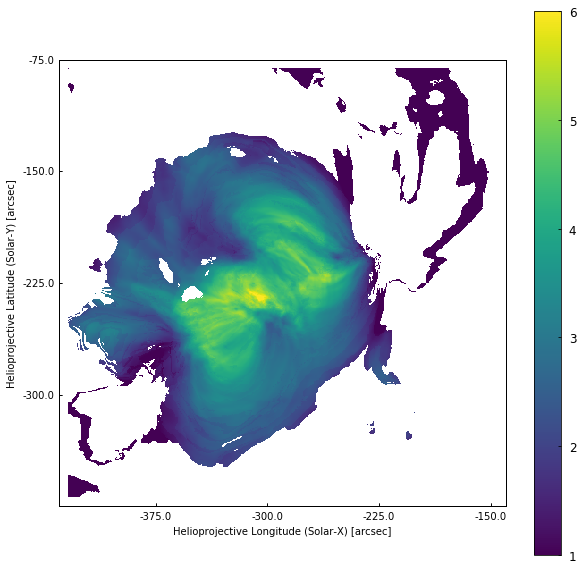

In [85]:
slope_map = em.make_slope_map(temperature_bounds=[1,4]*u.MK,em_threshold=1e20*u.cm**-5,rsquared_tolerance=0.9)
slope_map_observed = sunpy.map.Map(np.where(slope_map.data == 0, np.nan, slope_map.data),slope_map.meta)
#slope_map = slope_map.submap(slope_map.bottom_left_coord,
#                             SkyCoord(Tx=-220*u.arcsec,Ty=-100*u.arcsec,frame=slope_map.coordinate_frame))
fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection=slope_map_observed)
im = slope_map_observed.plot(axes=ax,cmap='viridis',vmin=1,vmax=6,title=False)
ax.grid(alpha=0)
fig.colorbar(im,ax=ax)

## Comparing Slopes

In [99]:
lc = u.Quantity([-360,-290],'arcsec')
rc = u.Quantity([-230,-180],'arcsec')

In [235]:
gs = matplotlib.gridspec.GridSpec(2,4)

/Users/willbarnes/anaconda/envs/synthesized-timelags/lib/python3.6/site-packages/ipykernel/__main__.py:40: RuntimeWarning: invalid value encountered in greater
/Users/willbarnes/anaconda/envs/synthesized-timelags/lib/python3.6/site-packages/ipykernel/__main__.py:41: RuntimeWarning: invalid value encountered in greater
/Users/willbarnes/anaconda/envs/synthesized-timelags/lib/python3.6/site-packages/ipykernel/__main__.py:45: RuntimeWarning: invalid value encountered in greater
/Users/willbarnes/anaconda/envs/synthesized-timelags/lib/python3.6/site-packages/ipykernel/__main__.py:46: RuntimeWarning: invalid value encountered in greater
/Users/willbarnes/anaconda/envs/synthesized-timelags/lib/python3.6/site-packages/ipykernel/__main__.py:50: RuntimeWarning: invalid value encountered in greater
/Users/willbarnes/anaconda/envs/synthesized-timelags/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: invalid value encountered in greater
/Users/willbarnes/anaconda/envs/synthesi

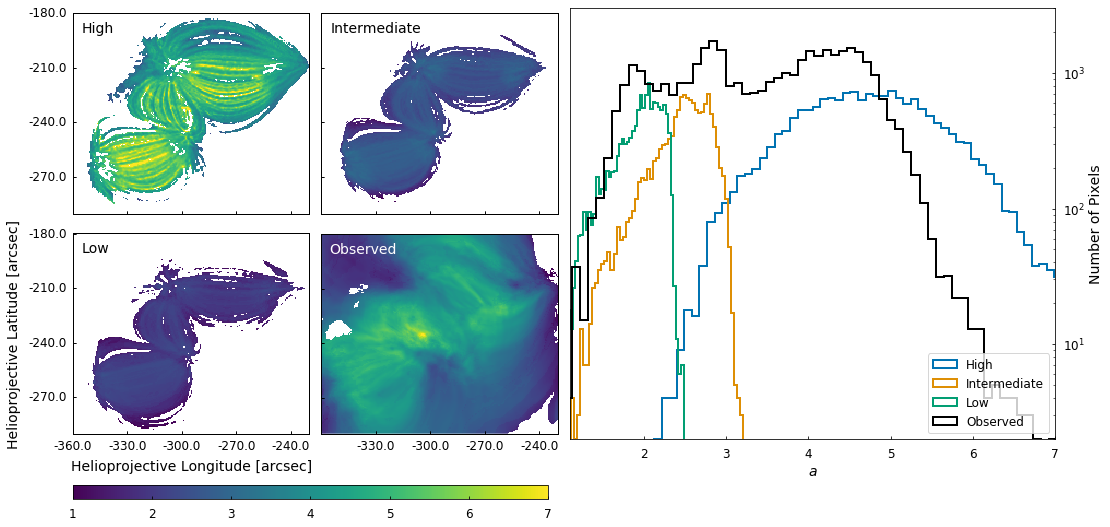

In [251]:
fig = plt.figure(figsize=get_figsize(wf=0.5,hf=0.45))
## Slope maps
cax = fig.add_axes([0.125,0.02,0.375,0.025])
pargs = {'title':False,'annotate':False,
         'norm':ImageNormalize(vmin=1,vmax=7),#,stretch=SqrtStretch()),
         'cmap':'viridis'}
labels = ['High','Intermediate', 'Low', 'Observed']
pos = [(0,0),(0,1),(1,0),(1,1)]
for i,m in enumerate([slope_map_high,slope_map_intermediate,slope_map_low,slope_map_observed]):
    sm = m.submap(SkyCoord(*lc,frame=m.coordinate_frame), SkyCoord(*rc,frame=m.coordinate_frame))
    ax = fig.add_subplot(gs[pos[i][0],pos[i][1]],projection=sm)
    im = sm.plot(axes=ax,**pargs)
    ax.grid(alpha=0)
    lon,lat = ax.coords
    if i < 2:
        lon.set_ticklabel_visible(False)
    else:
        if i==2:
            lon.set_axislabel(r'Helioprojective Longitude [arcsec]',fontsize=plt.rcParams['axes.labelsize'])
        lon.set_ticklabel(fontsize=plt.rcParams['xtick.labelsize'])
    if i%2 != 0:
        lat.set_ticklabel_visible(False)
    else:
        if i==2:
            lat.set_axislabel(r'Helioprojective Latitude [arcsec]',fontsize=plt.rcParams['axes.labelsize'])
        lat.set_ticklabel(fontsize=plt.rcParams['ytick.labelsize'])
    xtext,ytext = sm.world_to_pixel(SkyCoord(-355*u.arcsec,-190*u.arcsec,frame=sm.coordinate_frame))
    xtext,ytext = int(xtext.value),int(ytext.value)
    ax.text(xtext,ytext,labels[i],color='w' if labels[i]=='Observed' else 'k',
            fontsize=plt.rcParams['axes.labelsize'])
plt.subplots_adjust(hspace=0.05,wspace=0.05)
fig.colorbar(im,cax=cax,orientation='horizontal',)
## Histograms
ax = fig.add_subplot(gs[:,2:])
args = {'histtype': 'step', 'bins': 'fd','density':False,'log':True,'lw':2,}
colors = sns.color_palette(palette='colorblind',n_colors=3)
### High
sm = slope_map_high.submap(SkyCoord(*lc,frame=slope_map_high.coordinate_frame),
                           SkyCoord(*rc,frame=slope_map_high.coordinate_frame))
ax.hist(sm.data[sm.data > 0].flatten(),**args,label='High',color=colors[0]);
tot = sm.data[sm.data>0].flatten().tolist().copy()
### Intermediate
sm = slope_map_intermediate.submap(SkyCoord(*lc,frame=slope_map_intermediate.coordinate_frame),
                                   SkyCoord(*rc,frame=slope_map_intermediate.coordinate_frame))
ax.hist(sm.data[sm.data > 0].flatten(),**args,label='Intermediate',color=colors[1]);
tot += sm.data[sm.data>0].flatten().tolist()
### Low
sm = slope_map_low.submap(SkyCoord(*lc,frame=slope_map_low.coordinate_frame),
                          SkyCoord(*rc,frame=slope_map_low.coordinate_frame))
ax.hist(sm.data[sm.data > 0].flatten(),**args,label='Low',color=colors[2]);
tot += sm.data[sm.data>0].flatten().tolist()
### Total model
#ax.hist(tot,**args,label='Total, Model',color='k',ls='--');
### Observed
sm = slope_map_observed.submap(SkyCoord(*lc,frame=slope_map_observed.coordinate_frame),
                               SkyCoord(*rc,frame=slope_map_observed.coordinate_frame))
ax.hist(sm.data[sm.data > 0].flatten(),**args,label='Observed',color='k');
ax.set_ylim(2,3e3);
ax.set_xlim(1.1,7)
ax.set_ylabel('Number of Pixels')
ax.set_xlabel(r'$a$')
ax.yaxis.tick_right()
ax.yaxis.set_label_position('right')
ax.legend(loc=4)
fig.savefig('../figures/em_slopes.pdf')